# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt



In [ ]:
pip install scipy==1.1.0

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30) 

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size
batch_size = 25

In [4]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

In [52]:
import numpy as np
np.random.seed(20)
random_numbers = np.random.randint(0, 31, size=20)  # 31 is exclusive
arr = np.unique(np.sort(random_numbers))

print(arr)

[ 0  2  3  7  8  9 11 15 16 19 20 21 22 26 27 28]


In [60]:
import numpy as np
np.random.seed(25)
random_numbers1 = np.random.randint(0, 31, size=25)  # 31 is exclusive
arr1 = np.unique(np.sort(random_numbers1))

print(arr1)

[ 1  3  4  5  7  8 12 13 15 18 20 22 23 24 25 26 28 29 30]


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = arr
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.10)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        data_remaining = len(t)%batch_size
        if(data_remaining != 0):
            batch_data = np.zeros((data_remaining,20,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((data_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(data_remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.10)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5
# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [36]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras import optimizers

#write your model here

First Base Model : Conv 3D Model with 5 epochs, 25 batch size
Without dropouts in Conv layer and with batch normalization
Input image size 100X100 , adam optimiser with learning rate 0.0002 with decay, 20 images as input out of 30

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
modelConv3D_1 = Sequential()
modelConv3D_1.add(Conv3D(8, (3,3,3), padding="same", input_shape=(20, 100, 100, 3)))
modelConv3D_1.add(Activation("relu"))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_1.add(Conv3D(16, (3,3,3), padding="same"))
modelConv3D_1.add(Activation("relu"))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_1.add(Conv3D(32, (3,3,3), padding="same"))
modelConv3D_1.add(Activation("relu"))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_1.add(Conv3D(64, (3,3,3), padding="same"))
modelConv3D_1.add(Activation("relu"))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

optimiser = tf.optimizers.Adam(lr=0.0002, decay=1e-6)

# compile model :
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_1.summary())
print("Total Params in model:", modelConv3D_1.count_params())


In [ ]:
#optimiser = #write your optimizer
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_1.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model1History = modelConv3D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(model1History.history['categorical_accuracy'])
plt.plot(model1History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model1History.history['loss'])
plt.plot(model1History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Second Base Model : Conv 3D Model with 20 epochs, 30 batch size Without dropouts in Conv layer and with batch normalization Input image size 100X100 , adam optimiser with learning rate 0.0002 without decay, 20 images as input out of 30. Dropout changed to 0.5

In [ ]:
modelConv3D_2 = Sequential()
modelConv3D_2.add(Conv3D(8, (3,3,3), padding="same", input_shape=(20, 100, 100, 3)))
modelConv3D_2.add(Activation("relu"))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_2.add(Conv3D(16, (3,3,3), padding="same"))
modelConv3D_2.add(Activation("relu"))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_2.add(Conv3D(32, (3,3,3), padding="same"))
modelConv3D_2.add(Activation("relu"))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_2.add(Conv3D(64, (3,3,3), padding="same"))
modelConv3D_2.add(Activation("relu"))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.5))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Dense(5, activation='softmax'))

optimiser = tf.optimizers.Adam(lr=0.0002)

# compile model :
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_2.summary())
print("Total Params in model:", modelConv3D_2.count_params())


In [ ]:
batch_size = 30
num_epochs = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model2History = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(model2History.history['categorical_accuracy'])
plt.plot(model2History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model2History.history['loss'])
plt.plot(model2History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Third Base Model : Conv 3D Model with 20 epochs, 30 batch size Without dropouts in Conv layer and with batch normalization Input image size 100X100 , adam optimiser with learning rate 0.0002 without decay, 20 images as input out of 30. Dropout changed to 0.25. Image Scale Ratio: 0.3


In [9]:
def generator_updated(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = arr
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.03)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        data_remaining = len(t)%batch_size
        if(data_remaining != 0):
            batch_data = np.zeros((data_remaining,20,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((data_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(data_remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.03)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [10]:
modelConv3D_3 = Sequential()
modelConv3D_3.add(Conv3D(8, (3,3,3), padding="same", input_shape=(20, 100, 100, 3)))
modelConv3D_3.add(Activation("relu"))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_3.add(Conv3D(16, (3,3,3), padding="same"))
modelConv3D_3.add(Activation("relu"))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_3.add(Conv3D(32, (3,3,3), padding="same"))
modelConv3D_3.add(Activation("relu"))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_3.add(Conv3D(64, (3,3,3), padding="same"))
modelConv3D_3.add(Activation("relu"))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_3.add(Flatten())
modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.5))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(5, activation='softmax'))

optimiser = tf.optimizers.Adam(lr=0.0002)

# compile model :
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_3.summary())
print("Total Params in model:", modelConv3D_3.count_params())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 100, 100, 8)   656       
                                                                 
 activation (Activation)     (None, 20, 100, 100, 8)   0         
                                                                 
 batch_normalization (BatchN  (None, 20, 100, 100, 8)  32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 50, 50, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 50, 50, 16)    3472      
                                                                 
 activation_1 (Activation)   (None, 10, 50, 50, 16)    0

2024-11-05 13:44:01.033938: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-05 13:44:01.034027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
batch_size = 30
num_epochs = 20
train_generator_updated = generator_updated(train_path, train_doc, batch_size)
val_generator_updated = generator_updated(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
model3History = modelConv3D_3.fit_generator(train_generator_updated, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_updated, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_267/3051150666.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3History = modelConv3D_3.fit_generator(train_generator_updated, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_267/3659705889.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/20


2024-11-05 13:44:22.395408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


22/23 [===========================>..] - ETA: 2s - loss: 2.2425 - categorical_accuracy: 0.2288

/tmp/ipykernel_267/3659705889.py:42: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


23/23 [==============================] - ETA: 0s - loss: 2.2409 - categorical_accuracy: 0.2278Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0513_43_45.039785/model-00001-2.24095-0.22775-1.61294-0.23000.h5
23/23 [==============================] - 84s 3s/step - loss: 2.2409 - categorical_accuracy: 0.2278 - val_loss: 1.6129 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.9796 - categorical_accuracy: 0.2534
Epoch 00002: saving model to model_init_2024-11-0513_43_45.039785/model-00002-1.97957-0.25339-1.65554-0.23000.h5
23/23 [==============================] - 76s 3s/step - loss: 1.9796 - categorical_accuracy: 0.2534 - val_loss: 1.6555 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/20
22/23 [===========================>..] - ETA: 2s - loss: 1.8919 - categorical_accuracy: 0.2864
Epoch 00003: saving model to model_init_2024-11-0513_43_45.039785/m

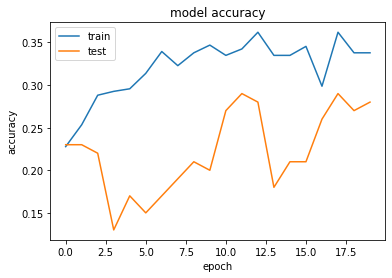

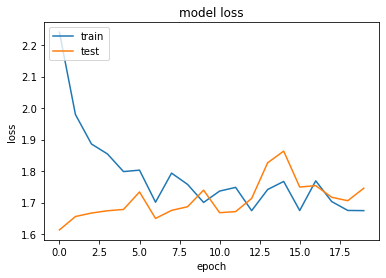

In [14]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(model3History.history['categorical_accuracy'])
plt.plot(model3History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model3History.history['loss'])
plt.plot(model3History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Fourth Base Model : Conv 3D Model with 30 epochs, 50 batch size Without dropouts in Conv layer and with batch normalization Input image size 100X100 , adam optimiser with learning rate 0.0002 without decay, 20 images as input out of 30. Dropout changed to 0.25. Image Scale Ratio: 0.3


In [15]:
modelConv3D_4 = Sequential()
modelConv3D_4.add(Conv3D(8, (3,3,3), padding="same", input_shape=(20, 100, 100, 3)))
modelConv3D_4.add(Activation("relu"))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_4.add(Conv3D(16, (3,3,3), padding="same"))
modelConv3D_4.add(Activation("relu"))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_4.add(Conv3D(32, (3,3,3), padding="same"))
modelConv3D_4.add(Activation("relu"))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_4.add(Conv3D(64, (3,3,3), padding="same"))
modelConv3D_4.add(Activation("relu"))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_4.add(Flatten())
modelConv3D_4.add(Dense(64, activation='relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(64, activation='relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(5, activation='softmax'))

optimiser = tf.optimizers.Adam(lr=0.0002)

# compile model :
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_4.summary())
print("Total Params in model:", modelConv3D_4.count_params())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 100, 100, 8)   656       
                                                                 
 activation_4 (Activation)   (None, 20, 100, 100, 8)   0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 100, 100, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 50, 50, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 50, 50, 16)    3472      
                                                                 
 activation_5 (Activation)   (None, 10, 50, 50, 16)   

In [16]:

batch_size = 50
num_epochs = 30
train_generator_updated = generator_updated(train_path, train_doc, batch_size)
val_generator_updated = generator_updated(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
	

In [ ]:
model4History = modelConv3D_4.fit_generator(train_generator_updated, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_updated, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
					
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(model4History.history['categorical_accuracy'])
plt.plot(model4History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model4History.history['loss'])
plt.plot(model4History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 5 : Conv 3D model
batch size 30, increased image inputs to 30 , image size recuced to 84

In [26]:
def generator_updated_reduced_size(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30)] 
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.03)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        data_remaining = len(t)%batch_size
        if(data_remaining != 0):
            batch_data = np.zeros((batch_size,30,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((data_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(data_remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.03)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [22]:
batch_size = 30
num_epochs = 20
train_generator_updated = generator_updated_reduced_size(train_path, train_doc, batch_size)
val_generator_updated = generator_updated_reduced_size(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
modelConv3D_5 = Sequential()
modelConv3D_5.add(Conv3D(8, (3,3,3), padding="same", input_shape=(30, 84, 84, 3)))
modelConv3D_5.add(Activation("relu"))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_5.add(Conv3D(16, (3,3,3), padding="same"))
modelConv3D_5.add(Activation("relu"))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_5.add(Conv3D(32, (3,3,3), padding="same"))
modelConv3D_5.add(Activation("relu"))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))


modelConv3D_5.add(Conv3D(64, (3,3,3), padding="same"))
modelConv3D_5.add(Activation("relu"))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

optimiser = tf.optimizers.Adam(lr=0.0002)

# compile model :
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_5.summary())
print("Total Params in model:", modelConv3D_5.count_params())



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_16 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 42, 42, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_17 (Activation)  (None, 15, 42, 42, 16)   

In [30]:
model5History = modelConv3D_5.fit_generator(train_generator_updated, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_updated, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_267/3481440363.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model5History = modelConv3D_5.fit_generator(train_generator_updated, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_267/1639779493.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
21/23 [==========================>...] - ETA: 6s - loss: 1.8566 - categorical_accuracy: 0.3032 

/tmp/ipykernel_267/1639779493.py:42: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
2024-11-05 15:05:17.366323: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[30,5] labels_size=[3,5]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits
 (defined at /usr/local/lib/python3.8/dist-packages/keras/backend.py:5009)
]] [Op:__inference_train_function_15907]

Errors may have originated from an input operation.
Input Source operations connected to node categorical_crossentropy/softmax_cross_entropy_with_logits:
In[0] categorical_crossentropy/softmax_cross_entropy_with_logits/Reshape:	
In[1] categorical_crossentropy/softmax_cross_entropy_with_logits/Reshape_1:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_267/3481440363.py", line 1, in <module>
>>>     model5History = modelConv3D_5.fit_generator(train_generator_updated, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 1664, in categorical_crossentropy
>>>     return backend.categorical_crossentropy(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 5009, in categorical_crossentropy
>>>     return tf.nn.softmax_cross_entropy_with_logits(
>>> 

In [ ]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(model5History.history['categorical_accuracy'])
plt.plot(model5History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model5History.history['loss'])
plt.plot(model5History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model 6 : CNN - LSTM Model

In [70]:
input_shape=(20,100,100,3)
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(128))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(128,activation='relu'))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = tf.optimizers.Adam()
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_1.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_50 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 20, 50, 50, 32) 

In [71]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = arr
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.10)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        data_remaining = len(t)%batch_size
        if(data_remaining != 0):
            batch_data = np.zeros((data_remaining,20,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((data_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(data_remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_img(image, 0.10)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalize and feed the image. 
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [72]:
batch_size = 30
num_epochs = 20
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_267/2841256302.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_267/3530338047.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/20
 2/23 [=>............................] - ETA: 33s - loss: 1.6826 - categorical_accuracy: 0.2667 